# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, GRU
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import setup_multi_gpus, create_corr_matrix, reduce_memory, resample_df, df_to_lstm_format

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

Using TensorFlow backend.


In [2]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

Amount of GPUs available: 1


# Load data

In [3]:
df = pd.read_csv('D://datc//opschaler//combined_gas_smart_weather_dfs//processed/all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df['dwelling'].unique()

array(['P01S01W7548', 'P01S02W0167', 'P01S01W5040', 'P01S01W8669',
       'P01S01W0000', 'P01S01W9617', 'P01S01W5588', 'P01S01W9431',
       'P01S01W4002', 'P01S01W7042', 'P01S01W6289', 'P01S01W5476',
       'P01S02W4827', 'P01S01W1554', 'P01S01W8828', 'P01S01W2743',
       'P01S01W5339', 'P01S01W1341', 'P01S01W5564', 'P01S01W2581',
       'P01S01W5746', 'P01S01W5292', 'P01S01W8655', 'P01S01W0998',
       'P01S01W4979', 'P01S01W6959', 'P01S01W4091', 'P01S02W6848',
       'P01S01W0373', 'P01S02W4953', 'P01S01W6595', 'P01S01W4489',
       'P01S01W5855', 'P01S01W3955', 'P01S01W4313', 'P01S01W6835',
       'P01S01W8239', 'P01S01W1347', 'P01S02W7251', 'P01S01W8171',
       'P01S01W7980', 'P01S01W7071', 'P01S01W3497', 'P01S01W6495',
       'P01S02W2995', 'P01S01W0378', 'P01S01W4589', 'P01S01W0001',
       'P01S01W4569', 'P01S01W6549', 'P01S01W4579', 'P01S02W5065'],
      dtype=object)

In [4]:
# Select a specific dwelling
#df = df[df['dwelling']=='P01S01W2743'] #with 10s the P01 part is missing! Needs to fix this later
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,RG,SQ,T,T10,TD,U,VV,WW,dwelling,gasPower
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-07 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,307.44101,305.450012,0.0,5.341667,...,0.0,7.631617,8.733334,9.133333,4.883333,76.500000,31916.666016,1.333333,P01S01W7548,NaN
2017-03-07 16:00:00,625.401001,0.0,359.501007,0.0,383.994446,0.0,307.44101,288.200012,0.0,5.418334,...,0.0,10.000000,9.116667,10.750000,5.416667,77.166664,23800.000000,2.666667,P01S01W7548,0.0
2017-03-07 17:00:00,625.679993,0.0,359.501007,0.0,277.722229,0.0,307.44101,285.866669,0.0,4.593333,...,0.0,2.936100,7.866667,8.450000,4.550000,78.833336,22233.333984,1.000000,P01S01W7548,0.0
2017-03-07 18:00:00,625.820984,0.0,359.501007,0.0,143.624283,0.0,307.44101,286.633331,0.0,3.783333,...,0.0,5.000000,7.066667,6.816667,4.433333,82.833336,20266.666016,2.500000,P01S01W7548,0.0
2017-03-07 19:00:00,625.963013,0.0,359.501007,0.0,143.376038,0.0,307.44101,278.783325,0.0,2.741667,...,0.0,0.000000,6.616667,6.016667,4.300000,84.666664,17433.333984,2.833333,P01S01W7548,0.0


In [5]:
df = df.dropna()
# Get an hour dataframe
df = resample_df(df, 'H', combine_all_dwellings=True)

#df['year'] = df.index.year
#df['month'] = df.index.month
#df['day'] = df.index.day
df['hour'] = df.index.hour #create column containing the hour
#df['minute'] = df.index.minute
#df['second'] = df.index.second
df['dayofweek'] = df.index.dayofweek
df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)

#df['perc.error'] = df['gasPower_std'] // df['gasPower']

df.head()

,ePower,ePowerReturn,DD,DR,FF,FX,N,P,Q,RG,...,TD,U,VV,WW,gasPower,dwelling,gasPower_std,hour,dayofweek,season
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-22 12:00:00,87.033333,0.0,240.149994,0.0,11.266666,16.063334,6.000000,1006.333313,90.166664,0.000000,...,8.216666,86.833336,14500.000000,2.000000,1.001953,All dwellings,NaN,12,2,1
2017-02-22 13:00:00,92.240356,0.0,236.633331,464.0,10.581667,15.056667,6.833333,1006.016663,71.333336,0.200000,...,8.400000,89.500000,11551.666992,63.333332,0.000000,All dwellings,NaN,13,2,1
2017-02-22 14:00:00,93.821724,0.0,234.149994,196.0,10.683333,15.986667,7.833333,1005.483337,91.500000,0.033333,...,8.516666,92.000000,11733.333008,48.500000,0.000000,All dwellings,NaN,14,2,1
2017-02-22 15:00:00,133.030640,0.0,237.500000,190.0,11.036667,16.288334,7.666667,1004.983337,51.500000,0.050000,...,8.500000,91.833336,12416.666992,49.000000,0.000000,All dwellings,NaN,15,2,1
2017-02-22 16:00:00,111.652779,0.0,237.649994,562.0,10.688334,14.911667,7.666667,1004.650024,26.833334,0.616667,...,8.533334,92.833336,7686.666504,71.166664,0.769043,All dwellings,NaN,16,2,1


c:\program files\python36\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Saving heatmap


<Figure size 432x288 with 0 Axes>

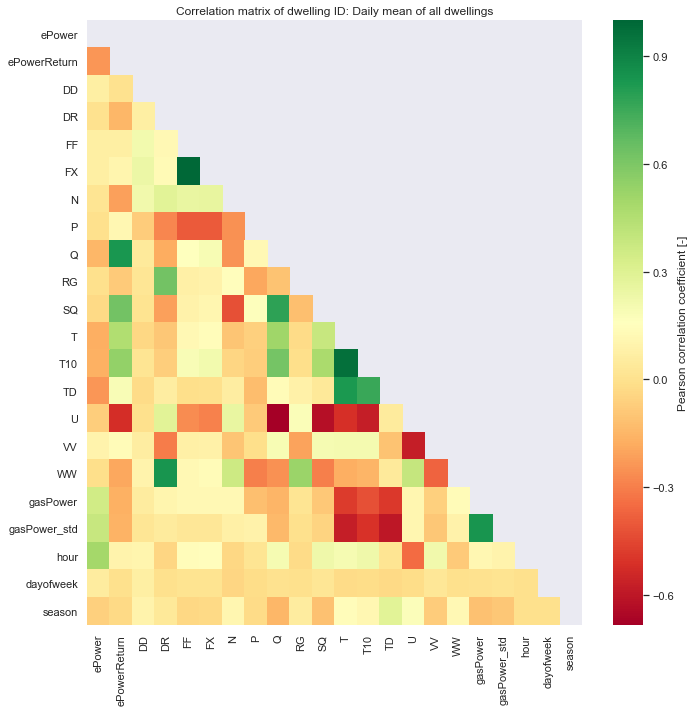

In [6]:
fig = create_corr_matrix(df, 'Daily mean of all dwellings', False, size=(10,10))
#fig.savefig('figures/pearon_all 12-11-2018.png', dpi=1300)

# Select data to use

Saving heatmap
Len of data:  6352


<Figure size 432x288 with 0 Axes>

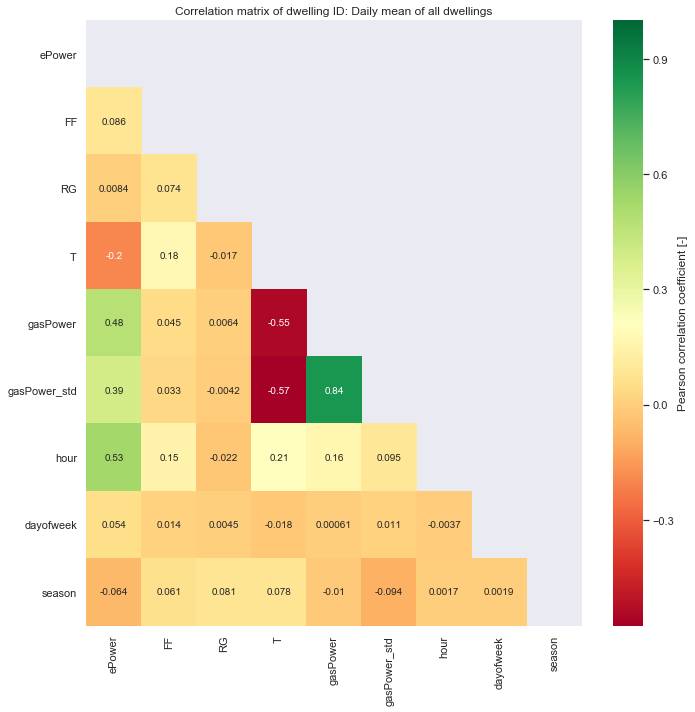

In [7]:
data = df
#data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter'], axis=1) # Not needed
data = data.drop(['dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

data = data.drop(['ePowerReturn'], axis=1) # Drop if want to predict gasPower

# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()


fig = create_corr_matrix(data, 'Daily mean of all dwellings', True, size=(10,10))

print('Len of data: ', len(data))

#plt.savefig('figures/Pearson 12-11-2018.png', dpi=1300)

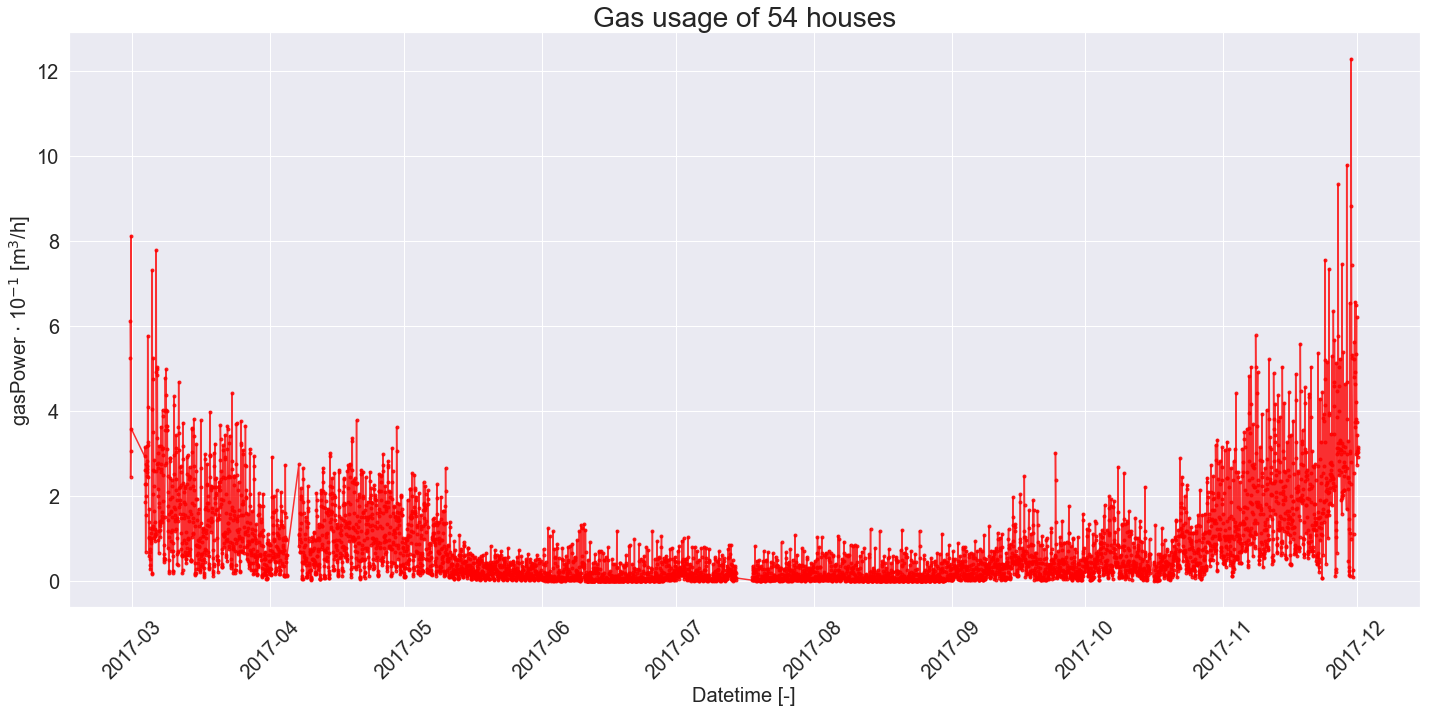

In [8]:
#### plt.figure(figsize=(20,10))

plt.figure(figsize=(20,10))
plt.plot(data.index, data['gasPower'], '.-', color='red', label='Original data', alpha=0.8)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % (magnitude), fontsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.title('Gas usage of 54 houses', fontsize=28)

plt.tight_layout()

#plt.savefig('figures/gass all houses.png', dpi=1200)

# Preprocessing

In [9]:
"""
Add a copy of gasPower column, so previous gasPower values are also in X_reshaped
"""
#data['gasPower_copy'] = data['gasPower']
#data['FF_copy'] = data['FF']
#data['RG_copy'] = data['RG']
#data['T_copy'] = data['T']

data.head()

,ePower,FF,RG,T,gasPower,gasPower_std,hour,dayofweek,season
datetime,,,,,,,,,
2017-02-28 12:00:00,308.321701,9.067500,0.0,5.183333,6.115723,0.085626,12,1,1
2017-02-28 13:00:00,263.656273,8.684999,0.0,5.300000,5.238647,0.318250,13,1,1
2017-02-28 14:00:00,181.913345,8.296667,0.0,5.283333,2.451172,0.041087,14,1,1
2017-02-28 15:00:00,378.613129,6.918334,0.0,5.516667,3.065186,0.214238,15,1,1
2017-02-28 16:00:00,332.392082,6.583333,0.0,5.433333,8.120117,0.014156,16,1,1


# datetime info to categorical

In [10]:
#columns_to_cat = ['year', 'month', 'day', 'hour', 'dayofweek', 'season']
columns_to_cat = ['dayofweek', 'hour', 'season']
data[columns_to_cat] = data[columns_to_cat].astype('category') # change datetypes to category

data = pd.get_dummies(data, columns=columns_to_cat) # One hot encoding the categories
data.head()

,ePower,FF,RG,T,gasPower,gasPower_std,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,season_1,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-28 12:00:00,308.321701,9.067500,0.0,5.183333,6.115723,0.085626,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2017-02-28 13:00:00,263.656273,8.684999,0.0,5.300000,5.238647,0.318250,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2017-02-28 14:00:00,181.913345,8.296667,0.0,5.283333,2.451172,0.041087,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2017-02-28 15:00:00,378.613129,6.918334,0.0,5.516667,3.065186,0.214238,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2017-02-28 16:00:00,332.392082,6.583333,0.0,5.433333,8.120117,0.014156,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


# Preprocessing, data to lstm format

In [11]:
look_back = 5*24 # D -> 5, H -> 5*24
num_features = data.shape[1] - 1
output_dim = 1
test_size = 0.7

X_train, y_train, X_test, y_test = df_to_lstm_format(df=data, test_size=test_size, look_back=look_back, target_column='gasPower', scale_X=True)

In [12]:
X_train.shape

(4326, 120, 40)

In [13]:
#print('X_train [0][0]: %s ' %  X_train[0])
#print('y_train [0]: %s ' % y_train[0])

In [14]:
def mape(y_true, y_pred):
    import keras.backend as K
    """
    Returns mean average percentage error (MAPE).
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

def smape(y_true, y_pred):
    import keras.backend as K
    """
    Returns the Symmetric mean absolute percentage error.
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_pred - y_true) / ((K.abs(y_true) + K.abs(y_pred))))*100

In [16]:
hidden_nodes = 5 # 35*2

# Create model
model = Sequential()

model.add(LSTM(hidden_nodes, input_shape=(look_back, num_features), return_sequences=False, kernel_initializer='TruncatedNormal'))
#model.add(Activation('sigmoid'))
#model.add(Activation('relu'))
model.add(LeakyReLU())
model.add(Dropout(0.2))


#for i in range(2):
#    model.add(LSTM(hidden_nodes, return_sequences=True, kernel_initializer='TruncatedNormal'))
#    model.add(LeakyReLU())
#    model.add(Dropout(0.2))
    
#model.add(LSTM(hidden_nodes, return_sequences=False, kernel_initializer='TruncatedNormal'))
#model.add(LeakyReLU())
#model.add(Dropout(0.2))

#N = 128 #45  
#for i in range(4):
#    model.add(Dense(N-i*4, kernel_initializer='TruncatedNormal'))
#    model.add(LeakyReLU())
    #model.add(Dropout(0.5))
    
#model.add(TimeDistributed(Dense(units=output_dim, kernel_initializer='TruncatedNormal')))
#model.add(Activation('linear'))

#model.add(Flatten())
model.add(Dense(1))

#model = multi_gpu_model(model, gpus=num_gpu)

In [ ]:
"""
Look back , 5
nodes, 35

More only makes the model more complex and harder/slower to train
"""

epochs = 200
bs = 2**11
lr = 1e-3
print(batch_size)

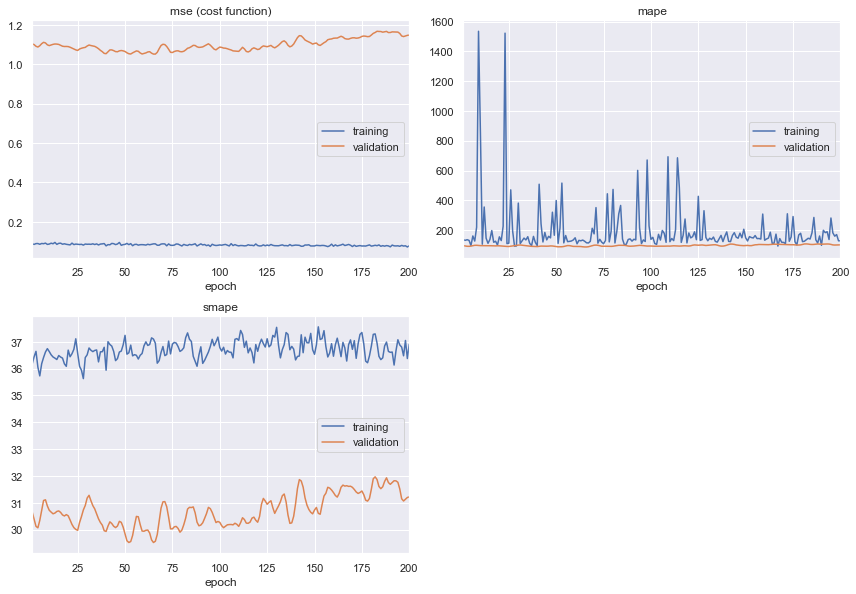

mse (cost function):
training   (min:    0.072, max:    0.095, cur:    0.078)
validation (min:    1.052, max:    1.168, cur:    1.148)

mape:
training   (min:   92.037, max: 1534.943, cur:  128.033)
validation (min:   86.789, max:  107.298, cur:  100.984)

smape:
training   (min:   35.629, max:   37.559, cur:   36.911)
validation (min:   29.520, max:   31.967, cur:   31.219)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5)                 920       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 5)                 0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 926
Trainable 

In [21]:
# 0.05 0.9 0 True
sgd = SGD(lr=0.5, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower
adam = Adam(lr=lr)

# compile & fit
model.compile(optimizer=adam, loss = ['mse'], metrics=[mape, smape])


early_stopping_monitor = EarlyStopping(patience=5000)



model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_data=(X_test, y_test),
         verbose=1, callbacks=[PlotLossesKeras(), early_stopping_monitor])

print(model.summary())

# Create plot

In [ ]:
y_preds = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_preds, '.-', color='blue', label='Predicted values')

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse = model.evaluate(X_test, y_test)[0]
mape = model.evaluate(X_test, y_test)[1]
smape = model.evaluate(X_test, y_test)[2]
plt.title('LSTM result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse, mape, smape), fontsize = 14)

#plt.savefig('figures/LSTM result hourly without dummy variables.png', dpi=1200)
print('FINISHED')

# Make the same plot, but downsample the results to a day

In [ ]:
# Get results, put it in a dataframe

y_preds = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

# Make it a df to be able to downsample
datetime = x.index
print(datetime.shape)

y_preds = y_preds.reshape(y_preds.shape[0])
y_true = y_true.reshape(y_true.shape[0])

results = pd.DataFrame(y_true, y_preds) # For some reason y_true becomes the index
result = results.reset_index() # Ugly way to fix above problem
result.columns = ['y_pred', 'y_true']

result['datetime'] = datetime
result = result.set_index(['datetime'])

result.to_csv('model _results _data/LSTM_predictions.csv')

result = result.resample('D').sum() # Resample data

result = result.dropna()

In [ ]:
# Calculate evaluation metrics over the result

ytrue = result['y_true']
ypred = result['y_pred']
n = len(result)

mse = (1/n)*np.sum((ypred - ytrue)**2)
mape = (100/n) * np.sum(np.abs((ytrue - ypred) / ypred))
smape = (100/n) * np.sum( np.abs((ytrue - ypred)) / (np.abs(ytrue) + np.abs(ypred)) )

In [ ]:
# Create plot
plt.figure(figsize=(20,10))
plt.plot(result.index, result['y_true'], '.-', color='red', label='Real values', alpha=0.5, ms=10) # ms is markersize
plt.plot(result.index, result['y_pred'], '.-', color='blue', label='Predicted values', ms=10)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

plt.title('LSTM result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse, mape, smape), fontsize = 14)

#plt.savefig('figures/LSTM result hourly resampled to daily by sum with no dummy variables.png', dpi=1200)